In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
file_path=r"C:\Users\Lenovo\Document\Engineering\Resume-Projects\Customer_churn\churn Prediction.xlsx"

In [13]:
sheet_name="vw_churndata"

data=pd.read_excel(file_path,sheet_name=sheet_name)

print(data.head())

  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   19877-DEL    Male   35      No        Delhi                    7   
1   58353-MAH  Female   45     Yes  Maharashtra                   14   
2   25063-WES    Male   51      No  West Bengal                    4   
3   59787-KAR    Male   79      No    Karnataka                    3   
4   28544-TAM  Female   80      No   Tamil Nadu                    3   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                27        NaN           Yes             No  ...   
1                13        NaN           Yes            Yes  ...   
2                35     Deal 5           Yes             No  ...   
3                21     Deal 4           Yes             No  ...   
4                 8        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0      Credit Card           65.6        593.30          0.00   
1      Credit Card          

In [9]:
import pandas as pd
from pathlib import Path

# because churn Prediction.xlsx sits in the same folder as your notebook:
file_path = Path("churn Prediction.xlsx")

# confirm file exists
print("Exists:", file_path.exists(), " — full path:", file_path.resolve())

# list sheet names
xls = pd.ExcelFile(file_path)
print("Sheets available:", xls.sheet_names)


Exists: True  — full path: C:\Users\Lenovo\Document\Engineering\Resume-Projects\Customer_churn\churn Prediction.xlsx
Sheets available: ['vw_churndata', 'vw_joindata', 'Sheet1']


In [12]:
df_churn = pd.read_excel(file_path, sheet_name="vw_churndata")
df_join = pd.read_excel(file_path, sheet_name="vw_joindata")

print(df_churn.head())
print(df_join.head())


  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   19877-DEL    Male   35      No        Delhi                    7   
1   58353-MAH  Female   45     Yes  Maharashtra                   14   
2   25063-WES    Male   51      No  West Bengal                    4   
3   59787-KAR    Male   79      No    Karnataka                    3   
4   28544-TAM  Female   80      No   Tamil Nadu                    3   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                27        NaN           Yes             No  ...   
1                13        NaN           Yes            Yes  ...   
2                35     Deal 5           Yes             No  ...   
3                21     Deal 4           Yes             No  ...   
4                 8        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0      Credit Card           65.6        593.30          0.00   
1      Credit Card          

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# assume `data` is your DataFrame already loaded
# safely drop only columns that exist (no error if missing)
cols_to_drop = ['Customer_ID', 'Churn_Category', 'Churn_Reason']
data = data.drop(columns=[c for c in cols_to_drop if c in data.columns])

# columns you intended to encode (restrict to those actually present)
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Internet_Backup', # <- typo guard
    'Online_Backup','Device_Protection_Plan', 'Premium_Support', 'Streaming_TV',
    'Streaming_Movies','Streaming_Music','Unlimited_Data','Contract',
    'Paperless_Billing','Payment_Method'
]
# keep only existing columns (and remove duplicates)
columns_to_encode = [c for c in columns_to_encode if c in data.columns]

# fill missing categoricals with a placeholder before label encoding
data[columns_to_encode] = data[columns_to_encode].fillna('Missing')

# apply LabelEncoder per column (ok for tree models)
label_encoders = {}
for col in columns_to_encode:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# encode target
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})
# if mapping creates NaN (unexpected values), convert them:
data['Customer_Status'] = data['Customer_Status'].fillna(0).astype(int)

# features / target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

# stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes:", X_train.shape, X_test.shape)


Shapes: (4805, 28) (1202, 28)


In [16]:
print(data.columns.tolist())


['Gender', 'Age', 'Married', 'State', 'Number_of_Referrals', 'Tenure_in_Months', 'Value_Deal', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue', 'Customer_Status']


In [19]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Confusion Matrix:
[[801  54]
 [128 219]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       855
           1       0.80      0.63      0.71       347

    accuracy                           0.85      1202
   macro avg       0.83      0.78      0.80      1202
weighted avg       0.84      0.85      0.84      1202



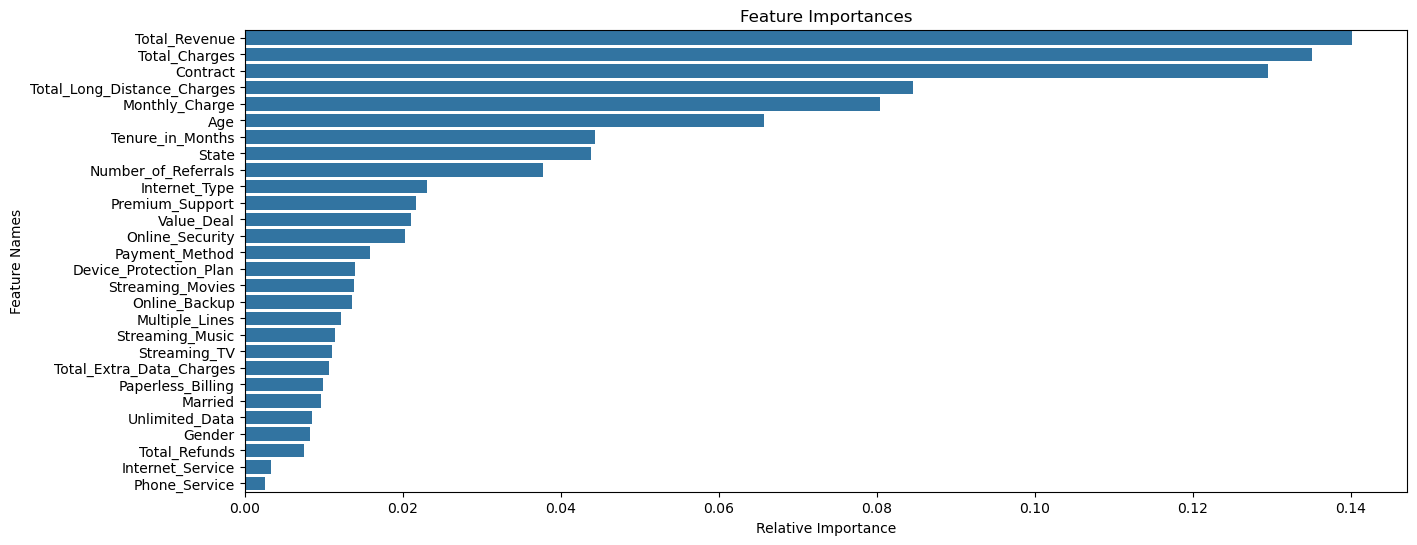

In [23]:
# Make predictions
import seaborn as sns
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()


In [24]:
import pandas as pd

# --- Step 1: Load new data ---
file_path = r"C:\Users\Lenovo\Document\Engineering\Resume-Projects\Customer_churn\churn Prediction.xlsx"
sheet_name = "vw_joindata"

new_data = pd.read_excel(file_path, sheet_name=sheet_name)
print(new_data.head())

# --- Step 2: Keep a copy for final output ---
original_data = new_data.copy()

# --- Step 3: Remove target column if exists ---
if 'Customer_Status' in new_data.columns:
    new_data = new_data.drop(['Customer_Status'], axis=1)

# --- Step 4: Store Customer_ID if exists ---
customer_ids = None
if 'Customer_ID' in new_data.columns:
    customer_ids = new_data['Customer_ID']
    new_data = new_data.drop(['Customer_ID'], axis=1)

# --- Step 5: Encode categorical columns using saved encoders ---
for column in new_data.columns:
    if new_data[column].dtype == 'object':
        if column in label_encoders:
            new_data[column] = label_encoders[column].transform(new_data[column])
        else:
            new_data[column] = new_data[column].astype("category").cat.codes

# --- Step 6: Make predictions ---
new_predictions = rf_model.predict(new_data)

# --- Step 7: Add predictions to original data ---
original_data['Customer_Status_Predicted'] = new_predictions

# --- Step 8: Filter churned customers only ---
churned_customers = original_data[original_data['Customer_Status_Predicted'] == 1]

# --- Step 9: Save results ---
output_path = r"C:\Users\Lenovo\Document\Engineering\Resume-Projects\Customer_churn\Predictions.csv"
churned_customers.to_csv(output_path, index=False)

print("Predictions saved to:", output_path)


  Customer_ID  Gender  Age Married           State  Number_of_Referrals  \
0   93520-GUJ  Female   67      No         Gujarat                   13   
1   57256-BIH  Female   18      No           Bihar                    9   
2   72357-MAD  Female   53      No  Madhya Pradesh                   14   
3   66612-KAR  Female   58     Yes       Karnataka                   11   
4   22119-WES    Male   31     Yes     West Bengal                    5   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                19     Deal 5           Yes            Yes  ...   
1                 7        NaN           Yes             No  ...   
2                12     Deal 5           Yes             No  ...   
3                18        NaN           Yes             No  ...   
4                 5        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal          72.10          72.1           0.0   
1      Cre

ValueError: invalid literal for int() with base 10: 'Female'